# Earth Mover's Distance

In [82]:
import numpy as np
import scipy as sp
from   scipy.linalg import solveh_banded
from   scipy.sparse import diags
import matplotlib.pyplot as plt
from   PIL import Image

In [83]:
def get_distributions(file0, file1, directory='../data/'):
    ''' Generate densities for EMD calculation

        The images are imported as grayscale. The
        values are then flipped so that the cats,
        originally shown in black, are shown in white
        and the background is black. Then the mass of
        each cat is normalized.
    '''
    img0 = Image.open(directory + file0).convert('L')
    img1 = Image.open(directory + file1).convert('L')

    rho0  = np.asarray(img0)
    rho0  = 255.0 * np.ones(rho0.shape) - rho0
    rho0 /= np.sum(rho0)

    rho1 = np.asarray(img1)
    rho1 = 255.0 * np.ones(rho1.shape) - rho1
    rho1 /= np.sum(rho1)

    rho0_has_unit_density = np.isclose(np.sum(rho0), 1)
    rho1_has_unit_density = np.isclose(np.sum(rho1), 1)
    assert rho0_has_unit_density
    assert rho1_has_unit_density

    rho0_is_square = rho0.shape[0] == rho0.shape[1]
    rho1_is_square = rho1.shape[0] == rho1.shape[1]
    assert rho0_is_square
    assert rho1_is_square

    rho0_rho1_are_same_size = rho0.shape[0] == rho1.shape[0]
    assert rho0_rho1_are_same_size

    n = rho0.shape[0]
    return rho0, rho1


def shrink(x, alpha):
    ''' Perform soft thresholding for either L1 or L2 norm.
    '''
    return np.sign(x) * np.maximum(np.abs(x) - alpha, 0)

def construct_K(n):
    ''' Construct a finite differencing matrix K and [K K.T] * [K.T; K].

        The matrix A takes the form [K K^T], where K is a backward discrete
        differencing operator. The product A * A^T = K * K^T + K^T * K is a
        triagonal matrix, which is used in constructing the Q matrix of the
        Proximal Nullspace Solver.
    '''
    K_full         = np.eye(n,n-1)
    K_full[1:, :] += -np.eye(n-1)
    K              = sp.sparse.csr_matrix(K_full)
    return K


def apply_div(z):
    ''' Compute the divergence of provide flux.

        Here the matrix K is a discrete differencing operator.
    '''
    n = int(z.shape[0] / 2 + 1)
    flux_shape_is_valid = n == z.shape[1]
    assert flux_shape_is_valid

    K   = construct_K(n)
    div = K @ z[:(n-1), :] + (K @ z[(n-1):, :]).T
    return div


## Code for Comparison Method PDHG

In [84]:
def update_stats(m, m_p, viol, obj, res, k, verbose=False):
    ''' Update arrays that store performance statistics.
    '''
    viol[k] = np.linalg.norm(apply_div(m) + rho1 - rho0)
    obj[k]  = np.sum(np.abs(m))
    res[k]  = np.linalg.norm(m - m_p, ord='fro')

    if k % 100 == 0 and verbose:
        print("[{:5d}]: |m - m_p| = {:0.3e}, |Am - b| = {:0.3e} obj = {:0.5e}".format(k, res[k], viol[k], obj[k]))

    return viol, obj, res


def PDHG(rho0, rho1, num_iters=500, verbose=False):
    ''' Apply Proximal Dual Hybrid Gradient to compute Earth Mover's Distance

        Convergence is ensured when mu * tau * lambd_max(div), where div is
        the matrix for the divergence operator.

        m = [mx; my^T]

        Boundary conditions are held by simply removing those "ghost entries"
        mx[-1, :]   = 0
        my^T[-1, :] = 0
        # m = [mx; my.T], x for i, y for j
    '''
    viol  = np.zeros(num_iters)
    obj   = np.zeros(num_iters)
    res   = np.zeros(num_iters)
    n     = rho0.shape[0]
    m     = np.zeros((2*(n-1),n))
    phi   = np.zeros((n,n))
    tau   = 1.0e4
    K     = construct_K(n)
    L     = 2.0 * np.linalg.norm(K.toarray().T @ K.toarray(), ord=2)
    mu    = 1.0 / (tau * L)

    for k in range(num_iters):
        m_p   = m.copy()
        Dphi  = np.concatenate((K.T @ phi, (K.T @ phi.T)), axis=0)
        m     = shrink(m - mu * Dphi, mu)
        div   = apply_div(2.0 * m - m_p)
        phi   = phi + tau * (div + rho1 - rho0)

        viol, obj, res = update_stats(m, m_p, viol, obj, res, k, verbose=verbose)

    return m, viol, obj, res


def GPDHG(rho0, rho1, num_iters=1000, eps=1.0e-10, verbose=False):
    ''' Apply G Prox PDHG
    '''
    viol  = np.zeros(num_iters)
    obj   = np.zeros(num_iters)
    res   = np.zeros(num_iters)
    n     = rho0.shape[0]
    u     = np.zeros((2*(n-1),n))
    p     = np.zeros((2*(n-1),n))

    K     = construct_K(n)

    tau     = 1.0e-4
    sigma   = 1.0 / tau

    ''' Get SVD '''
    U, S, Vt = np.linalg.svd(K.toarray(), full_matrices=True)
    S = np.concatenate((S,  np.zeros(n-S.shape[0])), axis=0)
    R = np.zeros(U.shape)

    for i in range(n):
        for j in range(n):
            R[i, j] += S[i] ** 2.0 + S[j] ** 2.0

    err      = rho1 - rho0
    err_norm = np.linalg.norm(err, ord='fro')
    t_hi     = ((2.0 * S[0]) ** 2.0) / (err_norm - eps)
    psi      = proj(np.zeros(u.shape), err, U, R, K, n, eps, t_hi=t_hi)

    for k in range(num_iters):
        p_p  = p.copy()
        u_p  = u.copy()

        p_t  = p + sigma * (u + psi)
        den  = np.maximum(np.ones(p.shape), np.abs(p_t))
        num  = p_t

        assert den.shape == num.shape

        p    = num / den

        p_norm = np.max(np.abs(p))
        assert p_norm <= 1.0, 'wrong p projection: ' + str(p_norm)

        err      = apply_div(2 * p - p_p)
        err_norm = np.linalg.norm(err, ord='fro')
        if err_norm > eps:
            t_hi = ((2.0 * S[0]) ** 2.0) / (err_norm - eps)
            u = u - tau * proj(2 * p - p_p, err, U, R, K, n, eps, t_hi=t_hi)
        else:
            u = np.zeros(u.shape)

        m_p = u_p + psi
        m   = u + psi
        viol, obj, res = update_stats(m, m_p, viol, obj, res, k, verbose=verbose)

    return m, viol, obj, res



## PP

In [85]:
def apply_inv(B, R, U, eps, tau):
    ''' Apply inverse
    '''
    num = U.T @ B @ U
    den = R + eps * tau
    inv = U @ (num / den) @ U.T
    return inv


def get_tau(B, R, U, eps, t_hi, t_lo=0.0, tol=1.0e-14):
    ''' bisection method...
    '''
    num      = U.T @ B @ U
    root_est = np.inf
    while np.abs(root_est) > tol:
        t        = 0.5 * (t_lo + t_hi)
        den      = R + eps * t
        root_est = t * np.linalg.norm(num / den) - 1.0
        if root_est > 0.0:
            t_hi = t
        else:
            t_lo = t
    return t


def proj(X, err, U, R, K, n, eps, t_hi):
    tau    = get_tau(err, R, U, eps, t_hi=t_hi)
    inv    = apply_inv(err, R, U, eps, tau)
    At_inv = np.concatenate((K.T @ inv, K.T @ inv.T), axis=0)
    P      = X - At_inv
    return P


def PP(rho0, rho1, alpha=1.0e-4, num_iters=500, eps=1.0e-10, verbose=False):
    ''' Apply Proximal Dual Hybrid Gradient to compute Earth Mover's Distance

        Convergence is ensured when mu * tau * lambd_max(div), where div is
        the matrix for the divergence operator.

        m = [mx; my^T]

        Boundary conditions are held by simply removing those "ghost entries"
        mx[-1, :]   = 0
        my^T[-1, :] = 0
    '''
    viol = np.zeros(num_iters)
    obj  = np.zeros(num_iters)
    res  = np.zeros(num_iters)
    n    = rho0.shape[0]
    m    = np.zeros((2*(n-1), n)) # m = [mx; my.T], x for i, y for j
    z    = np.zeros((2*(n-1), n))
    K    = construct_K(n)

    ''' Get SVD '''
    U, S, Vt = np.linalg.svd(K.toarray(), full_matrices=True)
    S = np.concatenate((S,  np.zeros(n-S.shape[0])), axis=0)
    R = np.zeros(U.shape)

    for i in range(n):
        for j in range(n):
            R[i, j] += S[i] ** 2.0 + S[j] ** 2.0

    for k in range(num_iters):
        m_p  = m.copy()

        err      = apply_div(z) + rho1 - rho0
        err_norm = np.linalg.norm(err, ord='fro')
        if err_norm > eps:
            t_hi = ((2.0 * S[0]) ** 2.0) / (err_norm - eps)
            m = proj(z, err, U, R, K, n, eps, t_hi=t_hi)
        else:
            m = z
        z = z + shrink(2.0 * m - z, alpha) - m

        viol, obj, res = update_stats(m, m_p, viol, obj, res, k, verbose=verbose)

    return m, viol, obj, res

## PyTests

## Execute Experiment

In [86]:
import time

rho0, rho1  = get_distributions('cat1.png', 'cat2.png')
num_trials  = 10
num_iters   = 20000
times_pp    = np.zeros(num_trials)
times_pdhg  = np.zeros(num_trials)
times_gpdhg = np.zeros(num_trials)

for t in range(num_trials):
    print('Trial {:2d} of {:2d}'.format(t+1, num_trials))
    print('Executing PP')
    start = time.time()
    m_pp,   viol_pp,   obj_pp,   res_pp   = PP(rho0,   rho1, num_iters=num_iters)
    times_pp[t] = time.time() - start
    print('Executing PDHG')
    start = time.time()
    m_pdhg, viol_pdhg, obj_pdhg, res_pdhg = PDHG(rho0, rho1, num_iters=num_iters)
    times_pdhg[t] = time.time() - start
    print('Executing G-Prox PDHG')
    start = time.time()
    m_gpdhg, viol_gpdhg, obj_gpdhg, res_gpdhg = GPDHG(rho0, rho1, num_iters=num_iters)
    times_gpdhg[t] = time.time() - start

print('avg pp time    = ', np.mean(times_pp))
print('avg pdhg time  = ', np.mean(times_pdhg))
print('avg gpdhg time = ', np.mean(times_gpdhg))


Trial  1 of 10
Executing PP
Executing PDHG
Executing G-Prox PDHG
Trial  2 of 10
Executing PP
Executing PDHG
Executing G-Prox PDHG
Trial  3 of 10
Executing PP
Executing PDHG
Executing G-Prox PDHG
Trial  4 of 10
Executing PP
Executing PDHG
Executing G-Prox PDHG
Trial  5 of 10
Executing PP
Executing PDHG
Executing G-Prox PDHG
Trial  6 of 10
Executing PP
Executing PDHG
Executing G-Prox PDHG
Trial  7 of 10
Executing PP
Executing PDHG
Executing G-Prox PDHG
Trial  8 of 10
Executing PP
Executing PDHG
Executing G-Prox PDHG
Trial  9 of 10
Executing PP
Executing PDHG
Executing G-Prox PDHG
Trial 10 of 10
Executing PP
Executing PDHG
Executing G-Prox PDHG
avg pp time    =  107.19988234043122
avg pdhg time  =  43.70859835147858
avg gpdhg time =  107.3787169456482


### Plot Densities and Divergence

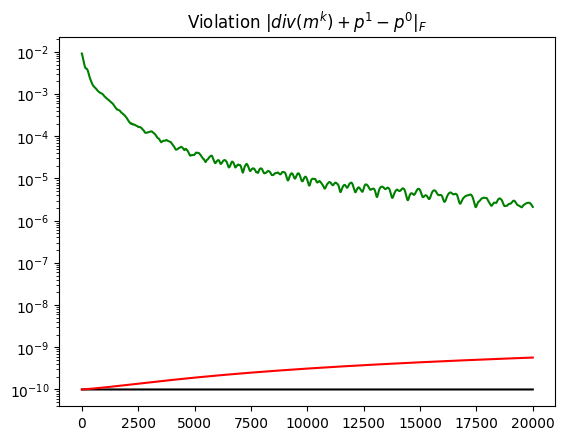

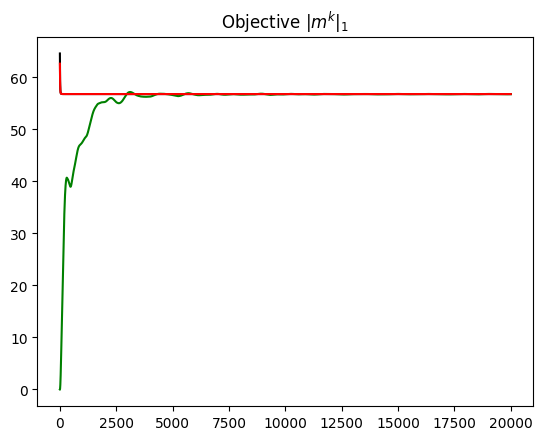

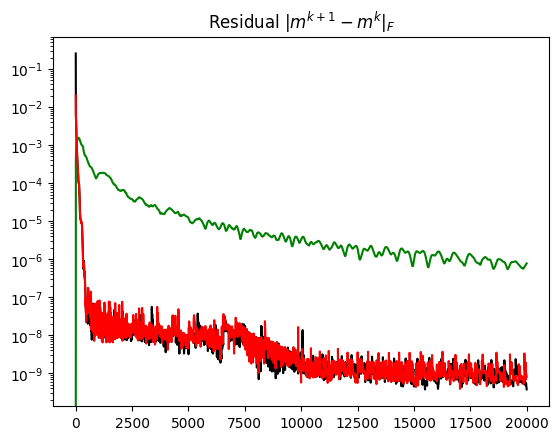

In [87]:
# Violation
fig, ax = plt.subplots()
plt.title('Violation $|div(m^k) + p^1 - p^0|_F $ ')
plt.plot(viol_pp,  color='k')
plt.plot(viol_pdhg, color='g')
plt.plot(viol_gpdhg, color='r')
plt.yscale('log')
plt.show()

# Objective
fig, ax = plt.subplots()
plt.title('Objective $|m^k|_{1}$')
plt.plot(obj_pp,  color='k')
plt.plot(obj_pdhg, color='g')
plt.plot(obj_gpdhg, color='r')
plt.show()

# Residual
fig, ax = plt.subplots()
plt.title('Residual $|m^{k+1}-m^k|_F$')
plt.plot(res_pp,  color='k')
plt.plot(res_pdhg, color='g')
plt.plot(res_gpdhg, color='r')
plt.yscale('log')
plt.show()

<Figure size 640x480 with 0 Axes>

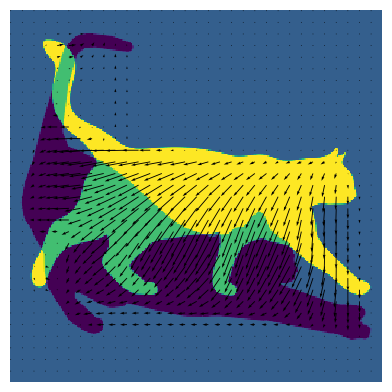

<Figure size 640x480 with 0 Axes>

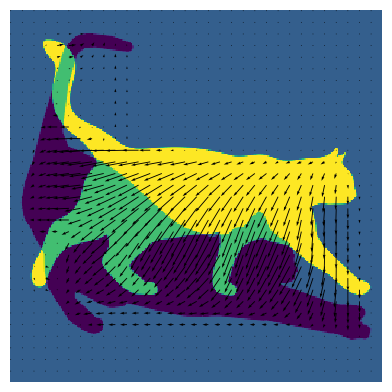

<Figure size 640x480 with 0 Axes>

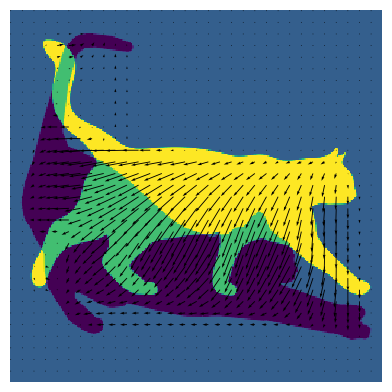

In [88]:
n = 256
d = 8
indices = d * np.arange(n/d)

for k, mm in enumerate([m_pp, m_gpdhg, m_pdhg]):
    # Create quiver plot for PP
    matrixi = -m_pp[:n:d, 0::d]   # vertical axis gets flipped for pictures (counts from top rather than bottom)
    matrixj =  m_pp[n::d, 0::d].T
    plt.figure()
    plt.matshow(2 * rho0 - rho1) # show both cats
    plt.quiver(indices, indices, matrixj, matrixi)
    plt.axis('off')
    if k == 0:
        plt.savefig('../results/emd-div-cat.png', bbox_inches='tight')
    plt.show()

In [89]:
filename = '../results/emd-viol-plots.csv'
with open(filename, 'w') as csv_file:
    for k in range(len(viol_pp)):
        if k % 5 == 0:
            csv_file.write('%0.5e,%0.5e,%0.5e\n' % (viol_pp[k], viol_pdhg[k],
                                              viol_gpdhg[k]))
filename = '../results/emd-obj-plots.csv'
with open(filename, 'w') as csv_file:
    for k in range(len(obj_pp)):
        if k % 5 == 0:
            csv_file.write('%0.5e,%0.5e,%0.5e\n' % (obj_pp[k], obj_pdhg[k],
                                              obj_gpdhg[k]))
filename = '../results/emd-res-plots.csv'
with open(filename, 'w') as csv_file:
    for k in range(len(res_pp)):
        if k % 5 == 0:
            csv_file.write('%0.5e,%0.5e,%0.5e\n' % (res_pp[k], res_pdhg[k],
                                              res_gpdhg[k]))

filename = '../results/emd-times.tex'
with open(filename, 'w') as csv_file:
    csv_file.write('\\def\\emdTimePP{%0.2f}'    % (np.mean(times_pp)))
    csv_file.write('\\def\\emdTimeGPDHG{%0.2f}' % (np.mean(times_gpdhg)))
    csv_file.write('\\def\\emdTimePDHG{%0.2f}'  % (np.mean(times_pdhg)))
    csv_file.write('\\def\\emdTimePPoverGPDHG{%0.1f}' % (np.mean(times_pp) / np.mean(times_gpdhg)))
    csv_file.write('\\def\\emdTimePPoverPDHG{%0.1f}'  % (np.mean(times_pp) / np.mean(times_pdhg)))

print('Plots have been saved.')

Plots have been saved.
